Based on results from notebook 16, modify to revert to multiple frames mapping to single target, maximizing the training points used (all consecutive subsets of 3 frames as input to CNN)

Experiment 56 - decent-ish results on train and test arrival times? Pending - doing `ConcatConv2D` to append time features, reporting summary stats and extending to multiple QoIs - see notebook 18 for these and more!

In [1]:
import sys
import torch
import torch.nn
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import os
import re
import sys
import logging
import torchvision
import torchvision.transforms as T

/Users/ajivani/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
args = {
    "niters":400,
    "lr": 0.001,
    "save": "arr_experiments/",
    "load": 56,
    # "load": None,
    "r": 1991,
    "resize_dims": (16, 64),
    "param_scaling": [1, 1],
    "warm_start": 20376,
    "do_warm_start": False,
    # "loss": "smooth_l1",
    "loss": "mae",
    # "loss": "mse",
    "batch_size": 32,
    "dropout":False
}

In [3]:
import torch.nn as nn

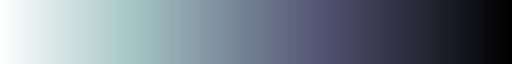

In [4]:
from sunpy.visualization import colormaps as cm

lc3_reg = cm.cmlist['soholasco3']
lc3_reg

lc3 = cm.cmlist['soholasco3'].reversed()
lc3

In [5]:
import time
import datetime
import argparse
from random import SystemRandom

from rich.progress import track
import tqdm

import matplotlib.pyplot as plt

import cnn_utils as cu

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

Filter out runs which arrive very late.

In [10]:
arr_times_data = pd.read_csv("./data_surrogate/UShift_CME3_120runs.csv")
arr_times_data = arr_times_data.dropna()

arr_times_data

,SIMID,shift,Tshock_sim,Tshock_obs
0,1,-18.0,70.0,52
2,3,-15.0,67.0,52
3,4,-7.0,59.0,52
4,5,-22.0,74.0,52
6,7,-4.0,56.0,52
...,...,...,...,...
114,116,7.0,45.0,52
115,117,19.0,33.0,52
116,118,16.0,36.0,52
117,119,5.0,47.0,52


In [11]:
data_sim_ids = arr_times_data['SIMID'].to_numpy()
data_arr_time = arr_times_data['Tshock_sim'].to_numpy()
data_shifts = arr_times_data['shift'].to_numpy()

In [12]:
# First split sim_ids, and arr_time into train and test.
# Based on this load param file for sims and index that

In [13]:
num_sim = len(data_sim_ids)
print(num_sim)

# train_size = np.int64(num_sim * 0.6)
# valid_size = np.int64(num_sim * 0.2)
# test_size = num_sim - train_size - valid_size
# print(train_size, valid_size, test_size)

train_frac, valid_frac, test_frac = 0.6, 0.15, 0.25

113


In [14]:
generator1 = torch.Generator().manual_seed(2024)
train_valid_test = random_split(data_sim_ids, 
                                [train_frac, valid_frac, test_frac],
                                # [train_size, valid_size, test_size],
                                generator=generator1)


In [15]:
data_sim_ids

array([  1,   3,   4,   5,   7,   9,  10,  11,  12,  13,  15,  16,  17,
        18,  19,  20,  21,  23,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120])

In [16]:
train_idx = np.array(train_valid_test[0].indices)
valid_idx = np.array(train_valid_test[1].indices)
test_idx = np.array(train_valid_test[2].indices)

In [17]:
train_sims = data_sim_ids[train_idx] - 1
val_sims = data_sim_ids[valid_idx] - 1
test_sims = data_sim_ids[test_idx] - 1

In [18]:
train_idx

array([  7,  43,  63,  33,  38,  73,  66,  20,  46,  80,  32,  21,  52,
        91, 101, 105,  35, 109,  19,  61,  82,  72,  92,  81,  90,   9,
        85,  39,  70,  40,  22,  45,  95,  24,  12,  97,   5,  67,  84,
        74, 110,  30,  71, 100,  37,  98, 102,  94,  57,  53,  75,  83,
       107,  42,  68,  69,  15,  59,  26,  10, 103, 112,  14,  56,  29,
       111,  87,  49])

In [19]:
ntrain = train_idx.shape[0]
nval = valid_idx.shape[0]
ntest = test_idx.shape[0]
ntrain, nval, ntest

(68, 17, 28)

In [20]:
all_idx = np.concatenate((train_idx, valid_idx, test_idx), axis=0)

In [21]:
all_idx.min(), all_idx.max()

(0, 112)

In [22]:
data_arr_time.shape

(113,)

In [23]:
data_arr_time

array([70., 67., 59., 74., 56., 88., 59., 85., 73., 86., 89., 52., 53.,
       78., 69., 67., 55., 61., 54., 59., 74., 71., 67., 51., 73., 56.,
       63., 51., 77., 62., 63., 72., 51., 49., 50., 74., 46., 71., 55.,
       61., 55., 67., 46., 65., 69., 56., 54., 51., 53., 64., 49., 44.,
       56., 50., 55., 47., 54., 73., 46., 43., 53., 66., 44., 38., 45.,
       54., 46., 46., 58., 50., 53., 47., 56., 43., 52., 39., 50., 63.,
       55., 40., 41., 56., 44., 38., 47., 62., 41., 40., 47., 38., 58.,
       39., 44., 37., 45., 49., 42., 39., 47., 35., 42., 33., 40., 40.,
       41., 36., 40., 41., 45., 33., 36., 47., 32.])

Split `data_arr_time` into multiple targets. If the time is T1 for a given sim, split it into T1-50, T1 - 52, ..., T1 - 180 to associate each image of a time series for parameter $\mu$ with a unique target.

In [24]:
all_timesteps = np.linspace(2, 180, 90, dtype=int)
tMinIdx = 50 # hardcoding for now, change later to accomodate variable length sequences
tMaxIdx = len(all_timesteps) - 1
nTimesteps = tMaxIdx - tMinIdx + 1



# scale time appropriately
tt_raw = np.linspace(all_timesteps[tMinIdx], all_timesteps[tMaxIdx], nTimesteps)
tt = np.linspace(0, 1, tMaxIdx - tMinIdx + 1)
tpredict = torch.Tensor(tt).to(device)

nTimesteps, tt_raw

(40,
 array([102., 104., 106., 108., 110., 112., 114., 116., 118., 120., 122.,
        124., 126., 128., 130., 132., 134., 136., 138., 140., 142., 144.,
        146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
        168., 170., 172., 174., 176., 178., 180.]))

In [25]:
data_arr_time_all_timesteps = np.zeros((num_sim, nTimesteps))
for i in range(num_sim):
    data_arr_time_all_timesteps[i, :] = data_arr_time[i] - (tt_raw / 60.0)

In [26]:
data_arr_time[2]

59.0

In [27]:
train_idx

array([  7,  43,  63,  33,  38,  73,  66,  20,  46,  80,  32,  21,  52,
        91, 101, 105,  35, 109,  19,  61,  82,  72,  92,  81,  90,   9,
        85,  39,  70,  40,  22,  45,  95,  24,  12,  97,   5,  67,  84,
        74, 110,  30,  71, 100,  37,  98, 102,  94,  57,  53,  75,  83,
       107,  42,  68,  69,  15,  59,  26,  10, 103, 112,  14,  56,  29,
       111,  87,  49])

In [28]:
# now split the all timesteps array correctly.

In [29]:
import sklearn
import copy

In [30]:
train_arr_raw = data_arr_time[train_idx]
val_arr_raw = data_arr_time[valid_idx]
test_arr_raw = data_arr_time[test_idx]

print(train_arr_raw.shape, val_arr_raw.shape, test_arr_raw.shape)

# pt = PowerTransformer(method='box-cox')
# pt = sklearn.preprocessing.RobustScaler()
pt = sklearn.preprocessing.MinMaxScaler()
pt.fit(train_arr_raw.reshape(-1, 1))

train_arr_pt = pt.transform(train_arr_raw.reshape(-1, 1))
val_arr_pt = pt.transform(val_arr_raw.reshape(-1, 1))
test_arr_pt = pt.transform(test_arr_raw.reshape(-1, 1))

(68,) (17,) (28,)


(array([ 5., 13., 12.,  8.,  9.,  8.,  5.,  4.,  0.,  4.]),
 array([32. , 37.7, 43.4, 49.1, 54.8, 60.5, 66.2, 71.9, 77.6, 83.3, 89. ]),
 <BarContainer object of 10 artists>)

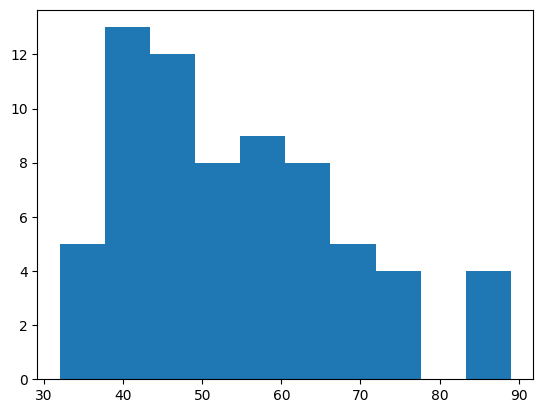

In [31]:
plt.hist(train_arr_raw.flatten())

(array([ 5., 13., 12.,  8.,  9.,  8.,  5.,  4.,  0.,  4.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

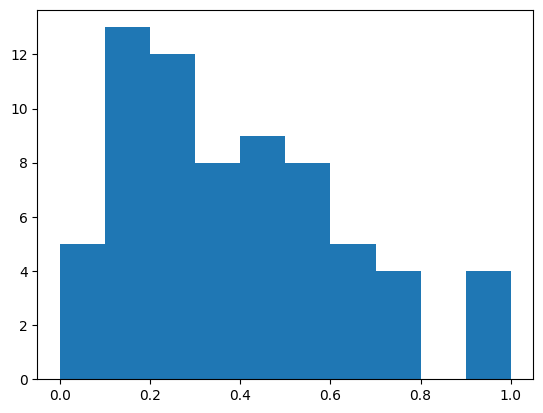

In [32]:
plt.hist(train_arr_pt.flatten())

In [33]:
# Process image datasets in pretty much the same way as before.

In [34]:
raw_datafile = np.load("./data_surrogate/CR2192_120runs_C3_ratio_PolarTensor.npy")

In [35]:
raw_datafile.shape

(128, 512, 90, 120)

In [36]:
raw_min, raw_max = raw_datafile.min(), raw_datafile.max()
raw_min, raw_max

(0.799298967364635, 1.5)

In [37]:
train_data_raw = raw_datafile[:, :, :, train_sims]
val_data_raw = raw_datafile[:, :, :, val_sims]
test_data_raw = raw_datafile[:, :, :, test_sims]

In [38]:
resize_dims = args["resize_dims"]

train_data_resized = T.Resize(size=resize_dims,
                                  antialias=True
                                  )(torch.Tensor(train_data_raw.transpose(3, 2, 0, 1)))
    
val_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(val_data_raw.transpose(3, 2, 0, 1)))

test_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(test_data_raw.transpose(3, 2, 0, 1)))

In [39]:
max_train = torch.max(train_data_resized)
min_train = torch.min(train_data_resized)

max_train, min_train

(tensor(1.5000), tensor(0.8940))

In [40]:
train_data = (train_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
val_data = (val_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
test_data = (test_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)

In [41]:
train_data.shape, val_data.shape, test_data.shape

(torch.Size([68, 40, 16, 64]),
 torch.Size([17, 40, 16, 64]),
 torch.Size([28, 40, 16, 64]))

In [42]:
train_data.max(), val_data.max(), test_data.max()

(tensor(1.), tensor(1.), tensor(1.))

### Concatenate parameters (optional)

In [43]:
raw_params = pd.read_csv("./data_surrogate/params_2192_120runs.csv")
raw_params = raw_params[["BStrength", "OrientationCme", "ApexHeight", "iHelicity"]]
raw_params

,BStrength,OrientationCme,ApexHeight,iHelicity
0,5.0417,347.475,0.8505,-1
1,5.1250,330.225,0.7196,1
2,6.7917,380.475,0.7482,1
3,5.3750,342.225,0.9123,-1
4,5.2917,322.725,0.8719,1
...,...,...,...,...
115,14.6250,300.225,0.6911,1
116,14.7083,371.475,0.9337,1
117,14.7917,348.225,0.7743,1
118,14.8750,312.975,0.7363,-1


In [44]:
raw_params.agg(['min', 'max'])

,BStrength,OrientationCme,ApexHeight,iHelicity
min,5.0417,294.975,0.6673,-1
max,14.9583,384.225,0.9504,1


In [45]:
raw_params_retained = raw_params.to_numpy()[data_sim_ids - 1, :]
raw_params_retained.shape

(113, 4)

In [46]:
# raw_params_np = raw_params_retained.to_numpy()

In [47]:
param_scaling = [15, 384, 0.95, 1]

In [48]:
raw_params_retained[train_idx, :].shape

(68, 4)

### Train-test split and normalization

Use train_idx, valid_idx and test_idx

In [49]:
train_params_raw = raw_params_retained[train_idx, :] / param_scaling
valid_params_raw = raw_params_retained[valid_idx, :] / param_scaling
test_params_raw = raw_params_retained[test_idx, :] / param_scaling

In [50]:
train_snaps = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
val_snaps = val_data.reshape((val_data.shape[0], val_data.shape[1], -1))
test_snaps = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

# repeat parameter values up to number of timesteps
train_params_ts = np.repeat(train_params_raw.reshape((train_params_raw.shape[0], train_params_raw.shape[1], 1)), nTimesteps, axis=2)
val_params_ts = np.repeat(valid_params_raw.reshape((valid_params_raw.shape[0], valid_params_raw.shape[1], 1)), nTimesteps, axis=2)
test_params_ts = np.repeat(test_params_raw.reshape((test_params_raw.shape[0], test_params_raw.shape[1], 1)), nTimesteps, axis=2)

# concatenate snaps and params
train_all = torch.cat((train_snaps, torch.Tensor(np.transpose(train_params_ts, (0, 2, 1)))), 2)
val_all = torch.cat((val_snaps, torch.Tensor(np.transpose(val_params_ts, (0, 2, 1)))), 2)
test_all = torch.cat((test_snaps, torch.Tensor(np.transpose(test_params_ts, (0, 2, 1)))), 2)

In [51]:
train_snaps.shape, val_snaps.shape

(torch.Size([68, 40, 1024]), torch.Size([17, 40, 1024]))

In [52]:
train_arr_ts = torch.Tensor(train_arr_pt)
val_arr_ts = torch.Tensor(val_arr_pt)
test_arr_ts = torch.Tensor(test_arr_pt)

train_arr_raw_ts = torch.Tensor(train_arr_raw).unsqueeze(1)
val_arr_raw_ts = torch.Tensor(val_arr_raw).unsqueeze(1)
test_arr_raw_ts = torch.Tensor(test_arr_raw).unsqueeze(1)

In [53]:
train_all.shape, val_all.shape, test_all.shape

(torch.Size([68, 40, 1028]),
 torch.Size([17, 40, 1028]),
 torch.Size([28, 40, 1028]))

In [54]:
ntrain, nval, ntest

(68, 17, 28)

In [55]:
train_dataset = []
val_dataset = []
test_dataset = []
for i in range(ntrain):
    for j in range(1, nTimesteps - 1):
        train_dataset.append((train_all[i:(i+1), (j-1):(j+2), :], train_arr_ts[i, :], train_arr_raw_ts[i, :]))

for i in range(nval):
    for j in range(1, nTimesteps - 1):
        val_dataset.append((val_all[i:(i+1), (j-1):(j+2), :], val_arr_ts[i, :], val_arr_raw_ts[i, :]))

for i in range(ntest):
    for j in range(1, nTimesteps - 1):
        test_dataset.append((test_all[i:(i+1), (j-1):(j+2), :], test_arr_ts[i, :], test_arr_raw_ts[i, :]))

In [56]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size = args["batch_size"],
                              shuffle=True, 
                              )

val_dataloader = DataLoader(val_dataset,
                            batch_size = args["batch_size"],
                            shuffle=False,
                            )

test_dataloader = DataLoader(test_dataset,
                             batch_size = len(test_dataset),
                             shuffle=False,
                             )

In [57]:
test_all.shape

torch.Size([28, 40, 1028])

In [58]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2584, 646, 1064)

In [59]:
def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

def get_next_batch(dataloader, device=torch.device("cuda:0")):
    return dataloader.__next__()

In [60]:
# blah = train_dataloader.__iter__().__next__()
# print(blah[0].shape, blah[1].shape, blah[2].shape)
# x_ip = blah[0][:, 0, :, :1024].reshape(-1, 3, 16, 64)
# x_param = blah[0][:, 0, 0, 1024:]
# x_ft = torch.flatten(model.features(x_ip), 1)
# x_ft_cat = torch.cat((x_ft, x_param), 1)
# model.regressor(x_ft_cat).shape

In [61]:
class WLCNN_Discrete(torch.nn.Module):
    def __init__(self, n_hidden_1,
                  n_hidden_2):
        super(WLCNN_Discrete, self).__init__()
        in_channels = 3

        self.features = torch.nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=3, padding=3),
            nn.BatchNorm2d(16),
            nn.ELU(),
            # nn.ELU(),
            # nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=1),
            # nn.BatchNorm2d(64),
            # nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )

        self.regressor = torch.nn.Sequential(
            # nn.Linear(1280, n_hidden_1),
            nn.Linear(1284, n_hidden_1),
            nn.BatchNorm1d(n_hidden_1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.BatchNorm1d(n_hidden_2),
            nn.Dropout(p=0.5),
            nn.ELU(),
            nn.Linear(n_hidden_2, 1)
        )

    def forward(self, x):
        x_ip = x[:, 0, :, :1024].reshape(-1, 3, 16, 64)
        x_param = x[:, 0, 0, 1024:]
        
        x_ft = self.features(x_ip)
        
        x_ft = torch.flatten(x_ft, 1)

        x_ft_cat = torch.cat((x_ft, x_param), 1)
        # xpred = self.regressor(x_ft)
        xpred = self.regressor(x_ft_cat)

        return xpred

    # def predict(self, x):
    #     xpred = self(x)
    #     return xpred

In [62]:
# model = WLCNN_Discrete(n_hidden_1=16,
#                        n_hidden_2=8).to(device)

In [63]:
import node_utils as nut
import data_utils as dut
import copy

In [64]:
model = WLCNN_Discrete(n_hidden_1=16,
                       n_hidden_2=8).to(device)
pmodel = nut.count_parameters(model)


print("Total number of parameters for model with concatenation: ", pmodel)

nut.makedirs(os.path.join(os.getcwd(), "arr_logs"))
logdir = os.path.join(os.getcwd(), "arr_logs")

exptdir = os.path.join(os.getcwd(), args["save"])
nut.makedirs(exptdir)

if args["load"] is not None:
    experimentID = args["load"]
    print("Loading experiment")
else:
    if args["do_warm_start"]==True:
        experimentID = args["warm_start"]
        print("Warm starting previous experiment")
    else:
        experimentID = int(SystemRandom().random() * 1e5)
        print("Starting New experiment")

print("Experiment ID: ", experimentID)

ckpt_path = ckpt_path = os.path.join(exptdir, "experiment_" + str(experimentID) + '.ckpt')

print("Checkpoint path: ", ckpt_path)

logger = dut.get_logger(logpath=os.path.join(logdir, "experiment_" + str(experimentID) + '.log'))

logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(pmodel))
logger.info(args)
logger.info(ckpt_path)
logger.info(device)

Total number of parameters for model with concatenation:  24241
Loading experiment
Experiment ID:  56
Checkpoint path:  /Users/ajivani/Desktop/Research/WLROM/WhiteLight/arr_experiments/experiment_56.ckpt
/Users/ajivani/Desktop/Research/WLROM/WhiteLight
WLCNN_Discrete(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Linear(in_features=1284, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.5, inplace=False)
    

In [66]:
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
if args["loss"] == "smooth_l1":
    criterion = nn.SmoothL1Loss().to(device)
elif args["loss"] == "mae":
    criterion = nn.L1Loss().to(device)
elif args["loss"] == "mse":
    criterion = nn.MSELoss().to(device)

# criterion = InverseBoxCoxLoss(pt)

print(criterion)
early_stopping = nut.EarlyStopping(patience=20,
                                verbose=True,
                                path=ckpt_path)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=40)
N_EPOCHS = args["niters"]

num_batches = 1
all_train_loss = []
all_valid_loss = []
ckpt_freq = 10
if args["load"] is None:
    if args["do_warm_start"] == True:
        checkpoint = torch.load(ckpt_path)
        model.load_state_dict(checkpoint['model'])
        start_epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Warm Starting Experiment {} from Epoch {}".format(experimentID, start_epoch))
    else:
        start_epoch = 0
        print("Starting a new experiment {} from Epoch {}".format(experimentID, start_epoch))

    # Resume training from specific epoch
    for itr in track(range(start_epoch + 1, num_batches * (args["niters"] + 1)), description="Looping over epochs..."):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        optimizer.zero_grad()

        for i, (raw_img, arr_target_scaled, arr_target) in enumerate(train_dataloader):
            raw_img = raw_img.to(device)
            # arr_target = arr_target.to(device)
            arr_target = arr_target_scaled.to(device)

            # Forward pass
            arr_pred = model(raw_img)

            # Compute Loss
            loss = criterion(arr_pred, arr_target)

            # Backward pass
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for i, (raw_img_val, arr_target_val_scaled, arr_target_val) in enumerate(val_dataloader):
                raw_img_val = raw_img_val.to(device)
                # arr_target_val = arr_target_val.to(device)
                arr_target_val = arr_target_val_scaled.to(device)

                # Forward pass
                arr_pred_val = model(raw_img_val)

                val_loss = criterion(arr_pred_val, arr_target_val)

                valid_loss += val_loss.item()

        train_loss = train_loss / len(train_dataloader)
        valid_loss = valid_loss / len(val_dataloader)

        all_train_loss.append(train_loss)
        all_valid_loss.append(valid_loss)


        message = 'Epoch {:04d}|Val loss {:.6e}|Train loss {:.6e}|LR {:.5f}|'.format(
                        itr//num_batches,
                        valid_loss,
                        train_loss,
                        optimizer.param_groups[0]["lr"])
        
        logger.info(message)
        scheduler.step(valid_loss)

        if itr % ckpt_freq == 0:
            early_stopping(val_loss, all_valid_loss, all_train_loss, model, optimizer, itr, args)

        if early_stopping.early_stop:
            logger.info("Early stopping")
            torch.save({'epoch': itr,
                    'model': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'all_train_loss': all_train_loss,
                    'all_valid_loss': all_valid_loss,
                    'args': args},
                    os.path.join(args["save"], "experiment_" + str(experimentID) + "_earlystopping.ckpt"))
            break
else:
    # check if early stopped model is available!
    early_stop_filepath = os.path.join(args["save"], "experiment_" + str(experimentID) + "_earlystopping.ckpt")

    if os.path.exists(early_stop_filepath):
        if args["load"] == 56:
            early_stp_ckpt = torch.load(early_stop_filepath)
            model.load_state_dict(early_stp_ckpt)
        else:
            nut.get_ckpt_model(early_stop_filepath, model, optimizer, device)
        print("Loading early stopped model ID {} from {}".format(experimentID, early_stop_filepath))
    else:
        nut.get_ckpt_model(ckpt_path, model, optimizer, device)
        print("Loading existing model ID {} from {}".format(experimentID, ckpt_path))


L1Loss()
Loading early stopped model ID 56 from arr_experiments/experiment_56_earlystopping.ckpt


In [67]:
if args["load"] is None: # can remove this loop condition for future experiments since early stopping will also save all_train_loss and all_valid_loss quantities henceforth (Sep 24)
    plt.plot(all_train_loss, label="train")
    plt.plot(all_valid_loss, label="val")
    plt.legend()

In [68]:
train_data_eval = DataLoader(train_dataset, 
        batch_size = len(train_dataset),
        shuffle=False, 
        )

train_eval_batch = get_next_batch(inf_generator(train_data_eval))

0.9979828558374385


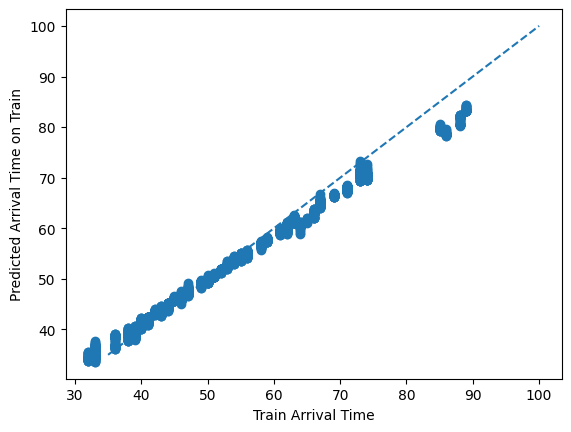

In [69]:
model.eval()
with torch.no_grad():
    train_preds_scaled = model(train_eval_batch[0]).cpu().numpy()

train_preds_unscaled = pt.inverse_transform(train_preds_scaled)
train_targets_all = train_eval_batch[2].cpu().numpy()

plt.scatter(train_targets_all, train_preds_unscaled)
plt.plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--')
plt.xlabel("Train Arrival Time")
plt.ylabel("Predicted Arrival Time on Train")

print(np.corrcoef(train_targets_all.flatten(), train_preds_unscaled.flatten())[1][0])

0.9804379529048162


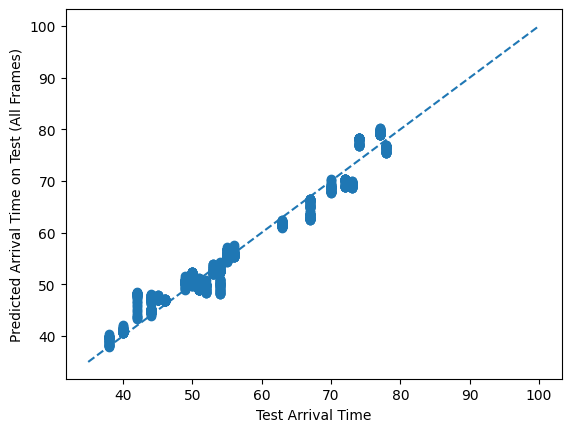

In [70]:
test_data_all = get_next_batch(inf_generator(test_dataloader))
# true_test_arrs = pt.inverse_transform(test_data_all[1].cpu().numpy())
true_test_arrs = test_data_all[2].cpu().numpy()
model.eval()
with torch.no_grad():
    test_preds = model(test_data_all[0].to(device)).cpu().numpy()

test_preds_unscaled = pt.inverse_transform(test_preds)

plt.scatter(true_test_arrs, test_preds_unscaled)
plt.plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--')
plt.xlabel("Test Arrival Time")
plt.ylabel("Predicted Arrival Time on Test (All Frames)")

print(np.corrcoef(true_test_arrs.flatten(), test_preds_unscaled.flatten())[1][0])

0.9804379529048162


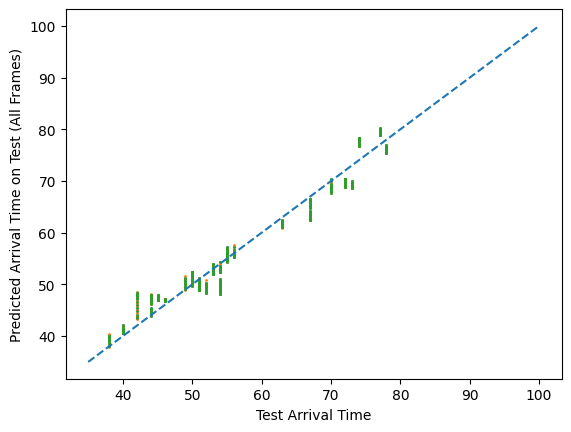

In [71]:
test_data_all = get_next_batch(inf_generator(test_dataloader))
# true_test_arrs = pt.inverse_transform(test_data_all[1].cpu().numpy())
true_test_arrs = test_data_all[2].cpu().numpy()
model.eval()
with torch.no_grad():
    test_preds = model(test_data_all[0].to(device)).cpu().numpy()

test_preds_unscaled = pt.inverse_transform(test_preds)

plt.scatter(true_test_arrs[0::2], test_preds_unscaled[0::2], s=1)
plt.scatter(true_test_arrs[1::2], test_preds_unscaled[1::2], s=1)
plt.scatter(true_test_arrs[2::2], test_preds_unscaled[2::2], s=1)

plt.plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--')
plt.xlabel("Test Arrival Time")
plt.ylabel("Predicted Arrival Time on Test (All Frames)")

print(np.corrcoef(true_test_arrs.flatten(), test_preds_unscaled.flatten())[1][0])